# Tymoteusz Cieślik

# Report: What if there was no time limit?

First of all, if the time was unlimited, it is important to analyze each of the variables separately. From the preliminary analysis it is possible to draw many useful insights about the data and check their behaviour. For example it would be beneficial to examine the correlation of variables, the reason for the missing data, check the distribution and statistical measures of attributes. It could be also viable to chceck the business meaning of each parameter even before the analysis. 

The next step should be composed of the data preparation, where the whole data set would be transformed into a form where it would be treated as a model input. If the computation time was not important, the dimensionality of data would not be problematic, as nowadays there exist methods that deal very well with this issue. On the other hand it could be possible to use some dimensionality reduction methods (such as PCA). There also exist possibility of discretizing some of the variables or transforming some categorical into continuous ones. Besides that, the thorough analysis of each variable could help to decide, if removing any rows or columns would result in inaccurate predictions. The use of all possible observations would also make ML models more general and together with the variance-bias tradeoff analysis would result in better predictions.

If it comes to models themselves, the input could be really huge, to minimalize the risk of inaccuracies. As the analysis of the most important features is also time-consuming it could be optimal to create a couple of different sets of variables and impose the ML model on them, in order to compare their performance by using different evaluation metrics. In addition the extensive hyperparameter tuning would help in improving the scores.  

At last the comparison between the models could be done by analysing the evaluation metrics for each model and decide which one performs the best. 

## Project with limited time

### Preliminary analysis

At first let us import some libraries which will be useful for the data analysis, preprocessing and in further work.

In [154]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.linear_model as skl
import sklearn as sk
import sklearn.model_selection as skm
from sklearn.preprocessing import MinMaxScaler
plt.rcParams['figure.figsize'] = [16,10]

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 1000

In [96]:
chunksize = 10000
data_sample = pd.read_csv("accepted_2007_to_2018Q4.csv",nrows=chunksize)

Let us choose one numerical attribute and one categorical, and perform some analysis on them. At first we can check the types of variables using .dtypes method. 

In [7]:
data_sample.dtypes

id                                              int64
member_id                                     float64
loan_amnt                                     float64
funded_amnt                                   float64
funded_amnt_inv                               float64
term                                           object
int_rate                                      float64
installment                                   float64
grade                                          object
sub_grade                                      object
emp_title                                      object
emp_length                                     object
home_ownership                                 object
annual_inc                                    float64
verification_status                            object
issue_d                                        object
loan_status                                    object
pymnt_plan                                     object
url                         

As we now know the types, we can arbitrarily select 'installment' and 'grade' as the attributes to examine. Firstly we would like to focus on the numerical one. It's important to find out whether there are some missing values.

In [3]:
data_analysis = pd.read_csv("accepted_2007_to_2018Q4.csv",usecols = ['installment','grade'])

numerical_var = data_analysis['installment']
np.sum(numerical_var.isna())

33

It appears that there only is a small amount of missing values, so omitting them will not affect the analysis.

In [239]:
numerical_var = numerical_var.dropna()

Now, we are able to present some statistical measures for the attribute.

In [240]:
pd.DataFrame(numerical_var.describe())

,installment
count,2.260668e+06
mean,4.458068e+02
std,2.671735e+02
min,4.930000e+00
25%,2.516500e+02
50%,3.779900e+02
75%,5.933200e+02
max,1.719830e+03


The raw values do not draw that much attention so that we will prepare a couple of visualizations presenting the distribution of values and explain their behaviour.

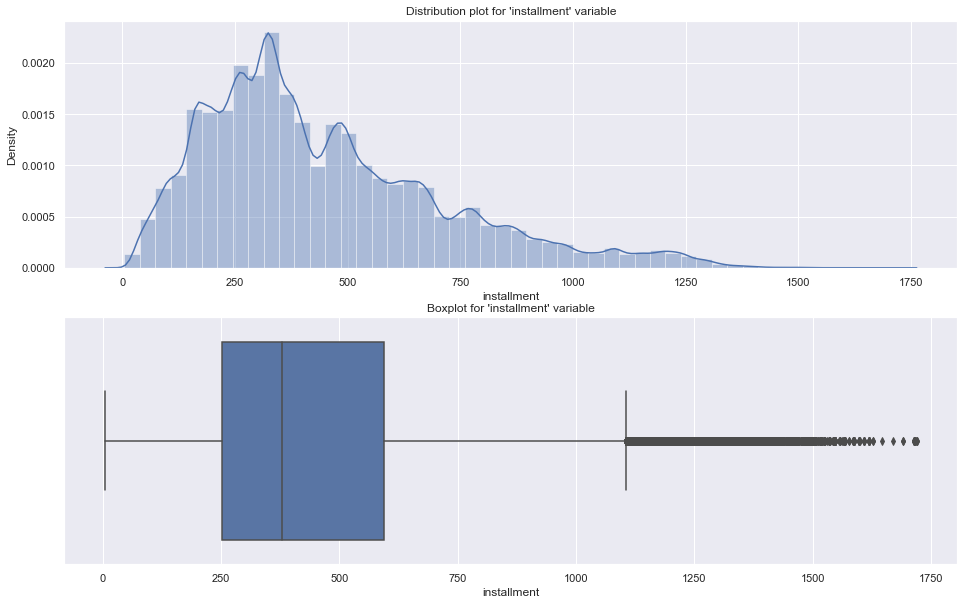

In [275]:
plt.subplot(2, 1, 1)
ax = sns.distplot(numerical_var)
ax.set_title("Distribution plot for 'installment' variable");

plt.subplot(2, 1, 2)
ax = sns.boxplot(numerical_var)
ax.set_title("Boxplot for 'installment' variable");

plt.show()

We notice that the distribution of installment values is right-skewed and is multimodal. The heavy tail is visible on the right hand side, what with the addition of boxplot can imply that there are some outliers. Most of the values are placed between the range of 0 and 1000 while the mean is approximately at 442.

We can now move on to the analysis of the categorical variable - 'grade'. At first we can check if there are some missing values and how many unique values are there. 

In [242]:
categorical_var = data_analysis['grade']
np.sum(categorical_var.isna())

33

Similarly as before we can omit these values and proceed further.

In [243]:
categorical_var = categorical_var.dropna()
categorical_var.unique()

array(['C', 'B', 'F', 'A', 'E', 'D', 'G'], dtype=object)

As we notice, there are 7 types of grade, probably indicating some kind of financial stability. We can show how many observations of each class there are.

In [244]:
categorical_var.value_counts()

B    663557
C    650053
A    433027
D    324424
E    135639
F     41800
G     12168
Name: grade, dtype: int64

It would be more clear if we saw it on a bar plot.

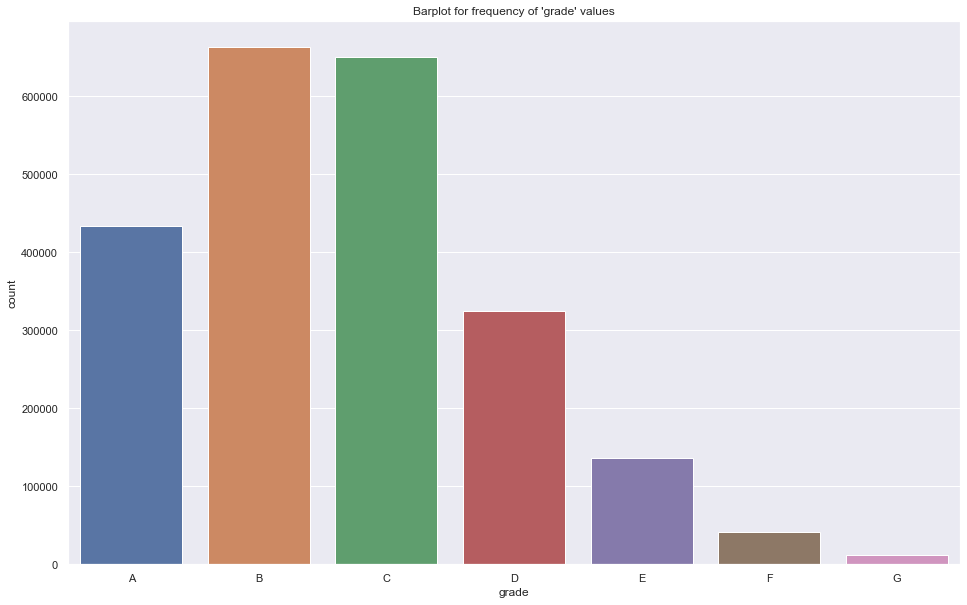

In [276]:
ax = sns.countplot(categorical_var, order = ['A','B','C','D','E','F','G'])
ax.set_title("Barplot for frequency of 'grade' values")
sns.set(rc={'figure.figsize':(5,5)})
plt.show()

The most common occurencies are B and C, while there is only a small percentage of grades that are equal to F or G.

## General data preprocessing

In this part we are going to focus on the preparation of the data so that it will be suitable as an input to the machine learning models. During this process we need to remember about a couple of things. As the dataset is huge, we will be working only on a sample of it, due to the relatively small memory of the user's computer. It could be possible to use big data multi-threading technologies for that reason, but the time for the task is limited, so we will abandon this approach. 

In fact, there are some steps that we are going to follow while transforming the data [1*]:
- At first in order to reduce dimensionality we decided to delete attributes, for which there is over 66% of information missing. 
- The next step is to extract the target variable and encode it correctly. 
- Then, we divide attributes into numeric and categorical ones, as different kind of data transformations is needed for each group. 
- After that we remove variabes for which there exist only one distinct value, as it would not contribute to the model, as well as variables for which there are too many distinct values because for the sake of further transformations it wouldn't be optimal and we can afford to treat it as one of the simplifications made. 
- For numeric data we decided to impute the missing values for each variable by assigning the mean values of the columns to the particular cells, then we normalized the data narrowing the range of values to [0,1] so that each factor could contribute evenly. 
- Concerning the categorical data, we also imputed missing values by assigning the most frequent value for each variable. Besides that, in order for the attributes to be used in ML models we had to encode their values in some kind of way. The best solution for that was to use one-hot encoding algorithm so that the information is preserved but at the cost of increasing the dimensionality of data and thus probable prolongation of computation time.


In [2]:
def normalize_data(data):
    """
    The function normalizes the numeric input by transforming the data and narrowing it to the range of [0,1]
    
    As the input it takes a pandas dataframe with numeric attributes
    
    It returns the normalized data as a form of pandas dataframe
    """
    scaler = MinMaxScaler(feature_range=(0, 1))
    norm = scaler.fit_transform(data)
    norm = pd.DataFrame(norm, columns = data.columns)
    return norm

In [3]:
def impute_numeric_data(numeric_data):
    """
    The function analyses whether there are any missing values in the numeric data and imputes them by assigning
    the mean value of the corresponding column. 
    
    As the input it takes a pandas dataframe with numeric attributes
    
    It returns imputed data as a form of pandas dataframe
    """
    na_exist_numeric = numeric_data.isna().sum()[numeric_data.isna().sum() >0 ]
    imputed_numeric_data = numeric_data
    for name in na_exist_numeric.index:
        imputed_numeric_data[name]=imputed_numeric_data[name].fillna(imputed_numeric_data[name].mean())
    return imputed_numeric_data

In [4]:
def impute_categorical_data(categorical_data):
    """
    The function analyses whether there are any missing values in the categorical data and imputes them by assigning 
    the most common value of the corresponding column. 
    
    As the input it takes a pandas dataframe with categorical attributes
    
    It returns imputed data as a form of pandas dataframe
    
    """
    na_exist_categorical = categorical_data.isna().sum()[categorical_data.isna().sum() >0 ]
    imputed_categorical_data = categorical_data
    imputed_categorical_data = imputed_categorical_data.fillna(imputed_categorical_data.mode().iloc[0])
    return imputed_categorical_data

In [5]:
def transform_categorical(categorical_data):
    """
    The fucntion uses one-hot encoding algorithm to transform categorical variables into numeric columns
    so that these attribues can be used for predictive modelling.
    
    As the input it takes a pandas dataframe with categorical attributes
    
    It returns transformed data as a form of pandas dataframe with binary values
    """
    categorical_imputed_onehot = pd.get_dummies(categorical_data)
    categorical_imputed_onehot.reset_index(inplace = True)
    categorical_imputed_onehot.drop('index',inplace=True,axis=1)
    return categorical_imputed_onehot

In [97]:
def prepare_data(csv_file, limit = 100000):
    """
    The function is used for the general preparation of the data, where all the steps, which are made, are described in the 
    introduction to this part of project [1*]
    
    As the input it takes a path to the .csv file that will be prepared and the number of rows to be loaded
    
    It returns transformed data as a form of merged pandas dataframe to be used as input to ML models and the target
    set in the form of vector with binary values. 
    """
    
    sample = pd.read_csv(csv_file, nrows = limit)
    sample = sample.dropna(axis = 1, how = 'all', thresh = 0.33*limit)
    sample.drop(sample['loan_status'].loc[sample['loan_status'] == "Current"].index, inplace=True)
    sample['loan_status'].loc[sample['loan_status']=='Fully Paid'] = 0
    sample['loan_status'].loc[sample['loan_status']!=0] = 1
    target_sample = sample['loan_status']
    target_sample=target_sample.astype('int')
    for col in sample.columns:
        if np.sum(sample[col].nunique()) == 1:
            sample.drop(col,inplace=True,axis=1)

    numerics = ['int64', 'float64']
    categoricals = 'object'
    numeric_data = sample.select_dtypes(include=numerics)
    categorical_data = sample.select_dtypes(include=categoricals)

    categorical_data.drop(['url','loan_status','emp_title','zip_code'],inplace=True,axis=1)
    numeric_data.drop('id', inplace=True, axis=1)
    imputed_numeric_data = impute_numeric_data(numeric_data)
    imputed_categorical_data = impute_categorical_data(categorical_data)
    norm_data = normalize_data(imputed_numeric_data)
    transformed_categorical = transform_categorical(imputed_categorical_data)
    data_all = pd.concat([norm_data, transformed_categorical], axis=1)
    return data_all, target_sample

In [98]:
filename = "accepted_2007_to_2018Q4.csv"
data_processed, target_processed = prepare_data(filename, limit = 100000)

Apart from that, we can notice a slight imbalance in the data, as the proportion of target values is close to 1:4.

In [126]:
np.sum(target_processed)/len(target_processed)

0.20666380730942008

## Building models

As we have prepared all the data to be treated as an input to the models we can focus now on the ML methods themselves. We've decided to use almost all of the proposed in the description of the task so that we will be able to broadly compare their performance and decide which one performs the best for the given data and parameters. The way we are going to evaluate the created models is the following,  there are four different metrics used for the classification problems that allow the assessment of the model's performance. They include: accuracy, AUC, precision and recall. 

Obtaining them is quite simple: we divide the data into training and test sets with the proportion of 80%/20%. We can achieve that by introduction of 5-fold cross validation, so that each sample of the data would be used for training and testing and thus the model will be considered as more general and will reduce the harmful impact of the data imbalance. 

The way we choose the methods is the following: at first we want to check the behaviour of a simple logistic regression, then by selecting more suitable variables we will be able to compare the performance and chceck whether there would be an improvement. The same situation applied to XGBoost algorithm, when at first we can check the scores for the default model and then compare it with its improved instance. At last we will implement the pruned decision tree in order to comare it to other models and find out on the visualization how the decision process is being held.

#### Logistic regression on whole data

The first considered method will be the logistic regression. We are going to use the whole dataset as an input to the model and then evaluate it. It does not seem to be the optimal solution but that way we will somehow try to find out whether the data transformations we made were done properly. Nevertheless, we will have an overall insight of the mehod performance by measuring the computation time of the model.

In [39]:
scorings_class = ['accuracy', 'roc_auc', 'precision', 'recall']

In [99]:
log_reg_model = skl.LogisticRegression()
%time log_reg_scores = skm.cross_validate(log_reg_model, np.array(data_processed), np.array(target_processed), cv=5,scoring=scorings_class)
log_reg_accuracy = np.mean(log_reg_scores['test_accuracy'])
log_reg_roc_auc = np.mean(log_reg_scores['test_roc_auc'])
log_reg_precision = np.mean(log_reg_scores['test_precision'])
log_reg_recall = np.mean(log_reg_scores['test_recall'])

Wall time: 1min 1s


In [186]:
scores_log_reg = {'Accuracy':[log_reg_accuracy],
              'AUC':[log_reg_roc_auc],
              'Precision':[log_reg_precision],
              'Recall':[log_reg_recall]}
scores_log_reg_table = pd.DataFrame.from_dict(scores_log_reg, orient='index',
                       columns=['LR']).transpose()
scores_log_reg_table

,Accuracy,AUC,Precision,Recall
LR,0.990654,0.999017,0.995131,0.95953


As we see in the table, the accuracy parameter is really high, reaching over 99%, other parameters also suggest a very good performance of the model.

#### Logistic regression with factor importance

This time as the input for the logistic regression we will use only a number of the most important variables for the prediction. Such approach greatly reduces the dimemsionality of the data and allows the faster computation time. In order to accomplish it we will use Random Forest algorithm that will indicate, which variables are the most suitable for the classification.

In [125]:
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = skm.train_test_split(data_processed, target_processed, test_size=0.2, random_state=42)
forest = RandomForestClassifier(random_state=42)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

That way we are able to obtain the most important features based on their mean decrease in impurity in random forest algorithm. We can then visualize the top 20 variables on the following graph to find out which ones are the most influential.

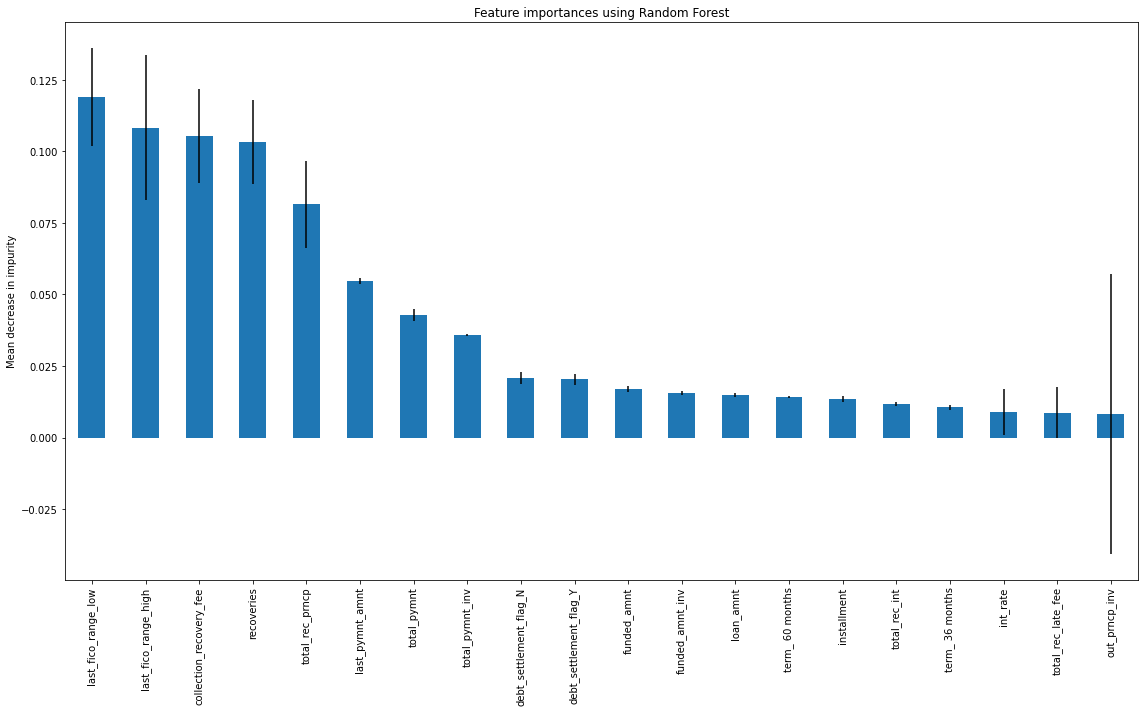

In [102]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances = pd.Series(importances, index=data_processed.columns)
forest_importances.sort_values(ascending= False, inplace = True)

fig, ax = plt.subplots()
forest_importances[0:20].plot.bar(yerr=std[0:20], ax=ax)
ax.set_title("Feature importances using Random Forest")
ax.set_ylabel("Mean decrease in impurity")
fig.set_size_inches(16, 10)
fig.tight_layout()

We notice that some of the variables are numeric and some are categorical. In the next step we can choose a number of the most important features which will be used as the input for the logistic regression. Let us set this value to 100. 

In [103]:
no_of_selected_attributes = 100
selected_attributes = data_processed[list(forest_importances[0:no_of_selected_attributes].index)]

In [104]:
log_reg_model_importance = skl.LogisticRegression()
%time log_reg_scores_importance = skm.cross_validate(log_reg_model_importance, np.array(selected_attributes), np.array(target_processed), cv=5,scoring=scorings_class)
log_reg_accuracy_importance = np.mean(log_reg_scores_importance['test_accuracy'])
log_reg_roc_auc_importance = np.mean(log_reg_scores_importance['test_roc_auc'])
log_reg_precision_importance = np.mean(log_reg_scores_importance['test_precision'])
log_reg_recall_importance = np.mean(log_reg_scores_importance['test_recall'])

Wall time: 17.9 s


We see that such approach is not as time-consuming as before and the results presented in the table below are even better.

In [185]:
scores_log_reg_importance = {'Accuracy':[log_reg_accuracy_importance],
              'AUC':[log_reg_roc_auc_importance],
              'Precision':[log_reg_precision_importance],
              'Recall':[log_reg_recall_importance]}
scores_log_reg_importance_table = pd.DataFrame.from_dict(scores_log_reg_importance, orient='index',
                       columns=['LR with factor importance']).transpose()
scores_log_reg_importance_table

,Accuracy,AUC,Precision,Recall
LR with factor importance,0.991061,0.999086,0.995186,0.961442


#### XGBoost with default parameters

This time we will implement the XGBoost method, which was developed much more recently and provides a quality way of classification. At first we will run the model with default parameters on all variables and check its performance. 
Due to the computational complexity we have limited the number of observations so that it takes a reasonable amout of time. 

In [110]:
import xgboost as xgb
model_XGB = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
%time XGB_scores = skm.cross_validate(model_XGB, np.array(data_processed[0:20000]), np.array(target_processed[0:20000]), cv=5,scoring=scorings_class,error_score="raise")
XGB_accuracy = np.mean(XGB_scores['test_accuracy'])
XGB_roc_auc = np.mean(XGB_scores['test_roc_auc'])
XGB_precision = np.mean(XGB_scores['test_precision'])
XGB_recall = np.mean(XGB_scores['test_recall'])

Wall time: 1min 11s


In the table below we can find out that the results are even better and the model performs very well.

In [184]:
scores_xgb = {'Accuracy':[XGB_accuracy],
              'AUC':[XGB_roc_auc],
              'Precision':[XGB_precision],
              'Recall':[XGB_recall]}
scores_xgb_table = pd.DataFrame.from_dict(scores_xgb, orient='index',
                       columns=['XGBoost']).transpose()
scores_xgb_table

,Accuracy,AUC,Precision,Recall
XGBoost,0.99565,0.999676,0.995426,0.983813


#### XGBoost with hyperparameter tuning

This time though, we will not change the input to the method, but we will try to tune the hyperparameters so that they are adjusted properly to the analysed data set. Due to the time limit, we will use grid search method only for some of the parameters with predetermined values.

In [149]:
from sklearn.model_selection import GridSearchCV

model_XGB_to_tune = xgb.XGBClassifier(use_label_encoder=False,eval_metric='mlogloss')

param_grid = {'eta': [0.01,0.05,0.1, 0.3, 0.5],
              'gamma': [0, 0.01, 0.1, 1],
              'colsample_bytree':[0.5,0.75,1,1.2]
             }
 
grid = GridSearchCV(model_XGB_to_tune, param_grid, scoring = scorings_class, cv = 5, verbose = 0, refit = False)
fitted = grid.fit(np.array(data_processed[0:20000]), np.array(target_processed[0:20000]))

After the tuning we are able to extract the values of hyperparameters for which the model performs the best and use them for the model training and evaluation. 

In [150]:
from statistics import mode
ranks = [fitted.cv_results_['rank_test_accuracy'][0]-1,fitted.cv_results_['rank_test_accuracy'][0]-1,fitted.cv_results_['rank_test_roc_auc'][0]-1,fitted.cv_results_['rank_test_precision'][0]-1]
CV_parameters = fitted.cv_results_['params'][mode(ranks)]
CV_parameters

{'colsample_bytree': 1, 'eta': 0.1, 'gamma': 0.01}

In [151]:
model_XGB_tuned = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss',colsample_bytree = 1, eta = 0.1, gamma = 1)
%time XGB_scores_tuned = skm.cross_validate(model_XGB_tuned, np.array(data_processed[0:20000]), np.array(target_processed[0:20000]), cv=5,scoring=scorings_class,error_score="raise")
XGB_accuracy_tuned = np.mean(XGB_scores_tuned['test_accuracy'])
XGB_roc_auc_tuned = np.mean(XGB_scores_tuned['test_roc_auc'])
XGB_precision_tuned = np.mean(XGB_scores_tuned['test_precision'])
XGB_recall_tuned = np.mean(XGB_scores_tuned['test_recall'])

Wall time: 1min 41s


In the table below we can see that the results of such adjustments are comparable to the ones achieved previously.

In [183]:
scores_xgb_tuned = {'Accuracy':[XGB_accuracy_tuned],
              'AUC':[XGB_roc_auc_tuned],
              'Precision':[XGB_precision_tuned],
              'Recall':[XGB_recall_tuned]}
scores_xgb_table_tuned = pd.DataFrame.from_dict(scores_xgb_tuned, orient='index',
                       columns=['Tuned XGBoost']).transpose()
scores_xgb_table_tuned

,Accuracy,AUC,Precision,Recall
Tuned XGBoost,0.9947,0.999508,0.994451,0.980242


#### Decision tree

The last implemented ML method will be the decision tree. Such approach is viable for different kinds of classification and with the help of pruning and visualization of the tree it is possible to better understand the data and process. At first we can fit the tree to the data.

In [157]:
tree = sk.tree.DecisionTreeClassifier(random_state=25)
%time tree_fitted = tree.fit(X_train, y_train)

Wall time: 15.6 s


The next step is to collect the list of available values of alpha - the parameter of cost complexity pruning.

In [160]:
path = tree_fitted.cost_complexity_pruning_path(np.array(data_processed[0:20000]), np.array(target_processed[0:20000]))
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Then we can evaluate different models which take as an input different values of alpha and select the one, for which the method performs the best.

In [163]:
path = tree_fitted.cost_complexity_pruning_path(np.array(data_processed[0:20000]), np.array(target_processed[0:20000]))
ccp_alphas, impurities = path.ccp_alphas, path.impurities
mean_cv_score = []
for alpha in ccp_alphas:
    ctree = sk.tree.DecisionTreeClassifier(random_state=25,ccp_alpha=alpha)
    scores = skm.cross_val_score(ctree, np.array(data_processed[0:20000]), np.array(target_processed[0:20000]), cv=5)
    mean_cv_score.append([np.mean(scores),alpha])
alpha_best = mean_cv_score[np.argmax(mean_cv_score, axis=0)[0]][1]

That way we create a decision tree with the optimal alpha and fit the tree to the data while evaluating the created model. Besides that it is possible to generate the resulting tree on a graph/diagram.

In [173]:
import graphviz
pruned_tree = sk.tree.DecisionTreeClassifier(random_state=25,ccp_alpha=alpha_best)
%time pruned_tree_scores = skm.cross_validate(pruned_tree, np.array(data_processed[0:20000]), np.array(target_processed[0:20000]), cv=5,scoring=scorings_class,error_score="raise")
pruned_tree_fitted = pruned_tree.fit(X_train, y_train)
pruned_graph = sk.tree.export_graphviz(pruned_tree_fitted, out_file=None, feature_names=X_train.columns, class_names=['0','1'], filled=True, rounded=True) 
graph_p = graphviz.Source(pruned_graph) 

Wall time: 32.9 s


In [174]:
tree_accuracy = np.mean(pruned_tree_scores['test_accuracy'])
tree_roc_auc = np.mean(pruned_tree_scores['test_roc_auc'])
tree_precision = np.mean(pruned_tree_scores['test_precision'])
tree_recall = np.mean(pruned_tree_scores['test_recall'])

In [182]:
scores_tree = {'Accuracy':[tree_accuracy],
              'AUC':[tree_roc_auc],
              'Precision':[tree_precision],
              'Recall':[tree_recall]}
scores_tree = pd.DataFrame.from_dict(scores_tree, orient='index',
                       columns=['Decision Tree']).transpose()
scores_tree

,Accuracy,AUC,Precision,Recall
Decision Tree,0.98755,0.989998,0.979628,0.960723


The scores seem to be very good, although not as high as in previously analysed models. 

In order to visualize the tree we can save the graph in a .png file...

In [179]:
import pydotplus
pydot_graph = pydotplus.graph_from_dot_data(pruned_graph)
pydot_graph.write_png('original_tree.png')

True

...and open it.

In [181]:
from PIL import Image
with Image.open('original_tree.png') as img:
    img.show()

## Summary

In the end we can summarize our predictions by creating the merged table of all evaluation scores, which can be visible below. It appears that the classification was generally very efficient, as the accuracy scores are around 0.99, what can be recognized as almost perfect. If we wanted to be attentive to details we would say that the best performance was achieved by the default XGB model, and the worst by the pruned decision tree. All in all, the analyses and data preprocessing we made turned out to be successful, and imposing the ML models on the resulting data set returned the desired effects. 

In [188]:
summary_table = pd.concat([scores_log_reg_table, scores_log_reg_importance_table, scores_xgb_table, scores_xgb_table_tuned, scores_tree], axis = 0)
summary_table

,Accuracy,AUC,Precision,Recall
LR,0.990654,0.999017,0.995131,0.959530
LR with factor importance,0.991061,0.999086,0.995186,0.961442
XGBoost,0.995650,0.999676,0.995426,0.983813
Tuned XGBoost,0.994700,0.999508,0.994451,0.980242
Decision Tree,0.987550,0.989998,0.979628,0.960723


However, due to the limited time and resources needed for the completion of the task we cannot be entirely sure, whether the applied approach would translate into the reality of implementation into production. Nevertheless, we can claim that the used methodologies and ways of dealing with the problem would be a sufficient simplification of the solution to the posed problem.